This notebook is an attempt at reproducing the results from [this notebook](https://github.com/noachr/MixMatch-fastai/blob/master/MixMatch%20Blog.ipynb). I decided to follow this approach as it seemed to get decent results (>80%) on just 500 training examples on the CIFAR dataset.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
from abc import abstractmethod
from typing import Any, Tuple, List, Dict, Union, Optional
from torchvision.transforms import v2
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as dl
from fastai.vision.all import *

In [ ]:
unlabeled_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(size=(32, 32), antialias=True),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
    ])

labeled_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(size=(32, 32), antialias=True),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=None)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=labeled_transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def get_indices(n_initial: int, X_size: int) -> np.ndarray:
  """
  This function generates the indices for the starting pool
  n_initial: size of the initial starting pool
  X_size: size of the full dataset
  """
  return np.random.choice(range(X_size), size=n_initial, replace=False)

# this probably needs refactoring at some stage
def get_pools(dataset: Any, labeled_idx: np.ndarray, unlabeled_idx: np.ndarray) -> Tuple[Any, Any]:
  """
  This function returns a tuple containing the labeled and unlabled pools
  dataset: raw dataset before splitting, should be an array-like data structure which support indexing
  initial_idx: indices for the starting pool
  """
  labeled_idxes = set(labeled_idx.flatten())
  unlabeled_idxes = set(unlabeled_idx.flatten())
  labeled_pool, unlabeled_pool = [], []
  for idx, sample in enumerate(dataset):
    if idx in labeled_idxes:
      labeled_pool.append(sample)
    elif idx in unlabeled_idxes:
      unlabeled_pool.append(sample)
  return labeled_pool, unlabeled_pool

In [ ]:
starting_indices = get_indices(n_initial=256, X_size=len(trainset))
labeled_indices = starting_indices[:128]
unlabeled_indices = starting_indices[128:]
labeled_pool, unlabeled_pool = get_pools(dataset=trainset, labeled_idx=labeled_indices, unlabeled_idx=unlabeled_indices)

In [ ]:
class CIFARALDataset(Dataset):
  def __init__(self, labeled_dataset: Union[np.ndarray, List], unlabeled_dataset: Optional[Union[np.ndarray, List]]):
    self.labeled_dataset = labeled_dataset
    self.unlabeled_dataset = unlabeled_dataset

  def __len__(self) -> int:
    return len(self.labeled_dataset)

  @abstractmethod
  def __getitem__(self, idx: int) -> None:
    raise NotImplementedError("This method needs to be implemented for a dataset to be created")

class SSLDataset(CIFARALDataset):

  def __init__(self, labeled_dataset: Union[np.ndarray, List], unlabeled_dataset: Union[np.ndarray, List]):
    super().__init__(labeled_dataset=labeled_dataset, unlabeled_dataset=unlabeled_dataset)

  def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
    ll_image, label = self.labeled_dataset[idx]
    ul_image, _ = self.unlabeled_dataset[idx]
    # return torch.cat([labeled_transform(ll_image), labeled_transform(ul_image), unlabeled_transform(ul_image)], dim=0), label
    return labeled_transform(ll_image), labeled_transform(ul_image), unlabeled_transform(ul_image), label

class TestDataset(Dataset):

  def __init__(self, dataset):
    self.dataset = dataset

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx: int):
    return self.dataset[idx]

class SLDataset(CIFARALDataset):

  def __init__(self, labeled_dataset: Union[np.ndarray, List]):
    super().__init__(labeled_dataset=labeled_dataset, unlabeled_dataset=None)

  def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
      image, label = self.labeled_dataset[idx]
      return labeled_transform(image), label

In [ ]:
train_bs, test_bs = 32, 64
test_set = [testset[i] for i in range(8192)]

ssl_dataloader = dl(dataset=SSLDataset(labeled_dataset=labeled_pool, unlabeled_dataset=unlabeled_pool),
                                batch_size=train_bs,
                                shuffle=True,
                                num_workers=2)

sl_dataloader = dl(dataset=SLDataset(labeled_dataset=labeled_pool),
                                  batch_size=train_bs,
                                  shuffle=True,
                                  num_workers=2)

test_dataloader = dl(dataset=TestDataset(dataset=test_set),
                     batch_size=test_bs,
                     shuffle=True,
                     num_workers=2)

In [ ]:
# Set k
K = 2

# sharpen
def sharpen(p,T=0.5):
    u = p ** (1/T)
    return u / u.sum(dim=1,keepdim=True)

# mixup
def mixup(a_x,a_y,b_x,b_y,alpha=0.75):
    l = np.random.beta(alpha,alpha)
    l = max(l,1-l)
    x = l * a_x + (1-l) * b_x
    y = l* a_y + (1-l) * b_y
    return x,y

# smoothen value
class SmoothenValue():
    "Create a smooth moving average for a value (loss, etc) using `beta`."
    def __init__(self, beta:float=0.98):
        self.beta,self.n,self.mov_avg = beta,0,0

    def add_value(self, val:float)->None:
        "Add `val` to calculate updated smoothed value."
        self.n += 1
        self.mov_avg = self.beta * self.mov_avg + (1 - self.beta) * val
        self.smooth = self.mov_avg / (1 - self.beta ** self.n)

In [ ]:
LayerFunc = Callable[[nn.Module],None]

def _bn(ni, init_zero=False):
    "Batchnorm layer with 0 initialization"
    m = nn.BatchNorm2d(ni)
    m.weight.data.fill_(0 if init_zero else 1)
    m.bias.data.zero_()
    return m

def bn_relu_conv(ni, nf, ks, stride, init_zero=False):
    bn_initzero = _bn(ni, init_zero=init_zero)
    return nn.Sequential(bn_initzero, nn.ReLU(inplace=True), conv2d(ni, nf, ks, stride))

def _make_group(N, ni, nf, block, stride, drop_p):
    return [block(ni if i == 0 else nf, nf, stride if i == 0 else 1, drop_p) for i in range(N)]

def conv2d(ni:int, nf:int, ks:int=3, stride:int=1, padding:int=None, bias=False, init:LayerFunc=nn.init.kaiming_normal_) -> nn.Conv2d:
    "Create and initialize `nn.Conv2d` layer. `padding` defaults to `ks//2`."
    if padding is None: padding = ks//2
    return init_default(nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=padding, bias=bias), init)

class BasicBlock(Module):
    "Block to from a wide ResNet."
    def __init__(self, ni, nf, stride, drop_p=0.0):
        self.bn = nn.BatchNorm2d(ni)
        self.conv1 = conv2d(ni, nf, 3, stride)
        self.conv2 = bn_relu_conv(nf, nf, 3, 1)
        self.drop = nn.Dropout(drop_p, inplace=True) if drop_p else None
        self.shortcut = conv2d(ni, nf, 1, stride) if ni != nf else noop

    def forward(self, x):
        x2 = F.relu(self.bn(x), inplace=True)
        r = self.shortcut(x2)
        x = self.conv1(x2)
        if self.drop: x = self.drop(x)
        x = self.conv2(x) * 0.2
        return x.add_(r)

class WideResNet(Module):
      "Wide ResNet with `num_groups` and a width of `k`."
      def __init__(self, num_groups:int, N:int, num_classes:int, k:int=1, drop_p:float=0.0, start_nf:int=16, n_in_channels:int=3):
          n_channels = [start_nf]
          for i in range(num_groups): n_channels.append(start_nf*(2**i)*k)

          layers = [conv2d(n_in_channels, n_channels[0], 3, 1)]  # conv1
          for i in range(num_groups):
              layers += _make_group(N, n_channels[i], n_channels[i+1], BasicBlock, (1 if i==0 else 2), drop_p)

          layers += [nn.BatchNorm2d(n_channels[num_groups]), nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d(1),
                    Flatten(), nn.Linear(n_channels[num_groups], num_classes)]
          self.features = nn.Sequential(*layers)

      def forward(self, x):
        return self.features(x)

In [ ]:
class MixupLoss(Module):
    def forward(self, preds, target):
      if preds.shape[0] != (K + 1) * train_bs:
          return F.cross_entropy(preds,target)
      preds_l = preds[:train_bs]
      preds_ul = preds[train_bs:]
      preds_l = torch.log_softmax(preds_l,dim=1)
      preds_ul = torch.softmax(preds_ul,dim=1)
      loss_x = -(preds_l * target[:train_bs]).sum(dim=1).mean()
      loss_u = F.mse_loss(preds_ul,target[train_bs:])
      self.loss_x, self.loss_u = loss_x, loss_u
      self.loss_u = loss_u
      return loss_x + loss_u

class MixMatchRecorder(Recorder):

  def __init__(self):
    super().__init__(add_time=True, train_metrics=False, valid_metrics=True, beta=0.98)

  def before_fit(self):
    super().before_fit()
    self.metric_names = self.metric_names + "loss_x" + "loss_u"

class MixMatchTrainer(Callback):
    _order=-20
    def before_fit(self):
        self.smoothL, self.smoothUL = SmoothenValue(), SmoothenValue()
        self.learn.loss_x, self.learn.loss_u = [], []

    def before_batch(self):
        if not self.training: return

        # get x and y of labeled dataset
        x_l, y_l = self.xb[0], self.yb[0]

        # get unlabeled image and all its associated augmentations
        x_ul, x_ul_a = self.xb[1], self.xb[2]

        # pass all unlabeled image augmentations through the model
        # average the predictions to get a pseudo label
        # perform sharpening on the pseudo label
        with torch.no_grad():
            ul_labels = sharpen(torch.softmax(torch.stack([self.learn.model(x_ul), self.learn.model(x_ul_a)],dim=1),dim=2).mean(dim=1))

        x_ul = torch.cat([x_ul, x_ul_a])
        ul_labels = torch.cat([y.unsqueeze(0).expand(K,-1) for y in ul_labels])

        # generates one-hot encoding of labels
        l_labels = torch.eye(len(classes)).cuda()[y_l]
        # l_labels = torch.eye(len(classes))[y_l]

        # concatenates all x and y
        # x now has shape 96, 3, 32, 32
        w_x = torch.cat([x_l,x_ul])
        # y now has shape 96, 10
        w_y = torch.cat([l_labels,ul_labels])
        # "shuffles" data randomly to perform mixup
        idxs = torch.randperm(w_x.shape[0])

        # perform mixup, generates mixup images and labels
        mixed_input, mixed_target = mixup(w_x,w_y,w_x[idxs],w_y[idxs])
        self.learn.xb, self.learn.yb = (mixed_input,), (mixed_target,)

    def after_loss(self):
      if not self.training: return
      ramp = self.iter / 100.0 if self.iter < 100 else 1.0
      loss_x = self.learn.loss_func.loss_x
      loss_u = 100 * ramp * self.learn.loss_func.loss_u
      loss_grad = loss_x + loss_u
      self.smoothL.add_value(loss_x)
      self.smoothUL.add_value(loss_u)
      self.learn.loss_grad = loss_grad

    def after_epoch(self):
      self.learn.loss_x.append(self.smoothL.smooth)
      self.learn.loss_u.append(self.smoothUL.smooth)


In [ ]:
model = WideResNet(num_groups=3,N=4,num_classes=10,k=2,start_nf=32)
data_semi_supervised = DataLoaders(ssl_dataloader, test_dataloader)
learn_semi_supervised = Learner(data_semi_supervised,model,loss_func=MixupLoss(),cbs=[MixMatchTrainer, Recorder],metrics=accuracy)

SuggestedLRs(valley=0.00019054606673307717)

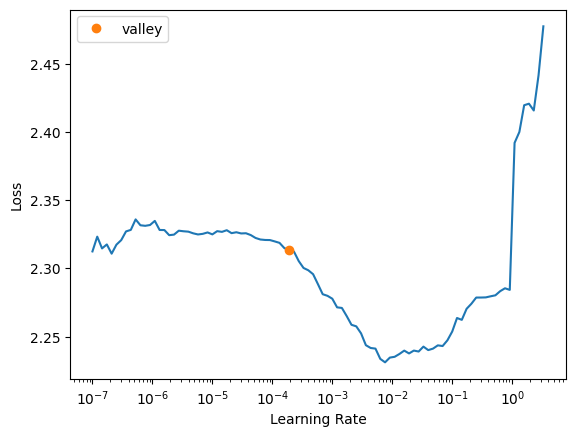

In [ ]:
learn_semi_supervised.lr_find()

In [ ]:
learn_semi_supervised.fit_one_cycle(200, 8e-4, wd=0.02)

epoch,train_loss,valid_loss,accuracy,time
0,2.324208,2.308433,0.105713,00:04
0,2.324208,2.308433,0.105713,00:04
1,2.328629,2.320261,0.107666,00:04
1,2.328629,2.320261,0.107666,00:04
2,2.319599,2.325729,0.108521,00:04
2,2.319599,2.325729,0.108521,00:04
3,2.308684,2.319334,0.112671,00:04
3,2.308684,2.319334,0.112671,00:04
4,2.299990,2.314586,0.122803,00:04
4,2.299990,2.314586,0.122803,00:04


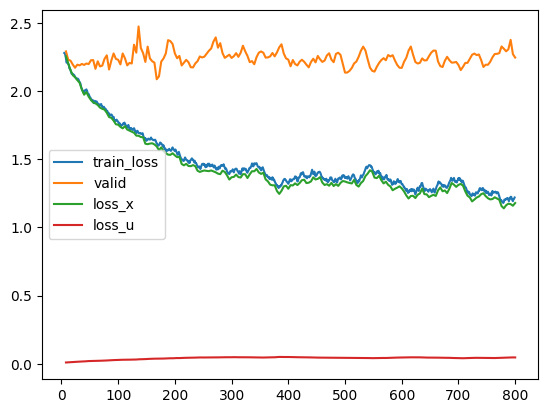

In [ ]:
skip_start = 5
recorder = learn_semi_supervised.recorder
loss_x = [x.to("cpu").item() for x in learn_semi_supervised.loss_x]
loss_u = [x.to("cpu").item() for x in learn_semi_supervised.loss_u]
plt.plot(list(range(skip_start, len(recorder.losses))), recorder.losses[skip_start:], label='train_loss')
idx = (np.array(recorder.iters)<skip_start).sum()
valid_col = recorder.metric_names.index('valid_loss') - 1
plt.plot(recorder.iters[idx:], L(recorder.values[idx:]).itemgot(valid_col), label='valid')
plt.plot(recorder.iters[idx:], loss_x[idx:], label='loss_x')
plt.plot(recorder.iters[idx:], loss_u[idx:], label='loss_u')
plt.legend()

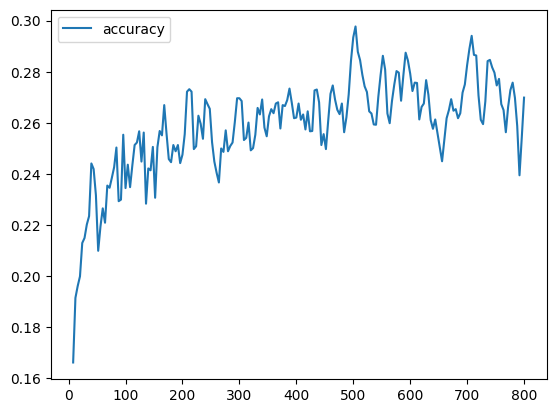

In [ ]:
acc = recorder.metric_names.index('accuracy') - 1
plt.plot(recorder.iters[idx:], L(recorder.values[idx:]).itemgot(acc), label='accuracy')
plt.legend()

In [ ]:
model1 = WideResNet(num_groups=3,N=4,num_classes=10,k=2,start_nf=32)
data_supervised = DataLoaders(sl_dataloader, test_dataloader)
learn_supervised = Learner(data_supervised,model1,loss_func=CrossEntropyLossFlat(),cbs=[MixUp, Recorder],metrics=accuracy)

SuggestedLRs(valley=0.0010000000474974513)

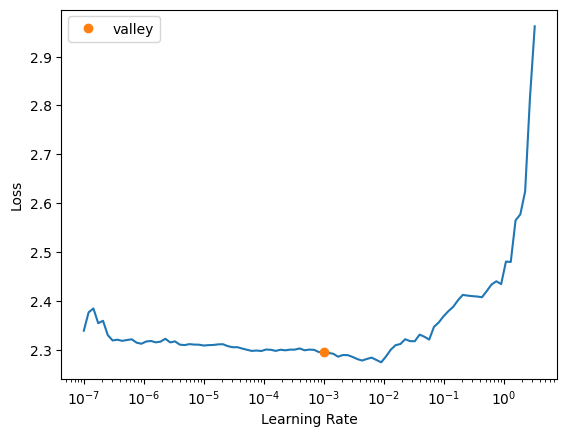

In [ ]:
learn_supervised.lr_find()

In [ ]:
learn_supervised.fit(200, 1e-3, wd=0.02)

epoch,train_loss,valid_loss,accuracy,time
0,2.323362,2.640740,0.121338,00:04
0,2.323362,2.640740,0.121338,00:04
1,2.240232,2.487592,0.149902,00:04
1,2.240232,2.487592,0.149902,00:04
2,2.188941,2.688699,0.168457,00:04
2,2.188941,2.688699,0.168457,00:04
3,2.149070,2.308148,0.213013,00:04
3,2.149070,2.308148,0.213013,00:04
4,2.108910,2.605127,0.196045,00:04
4,2.108910,2.605127,0.196045,00:04


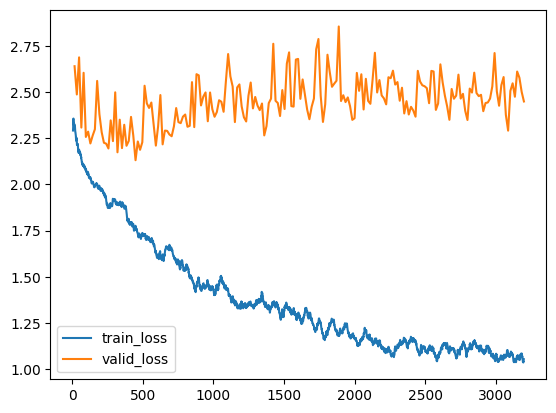

In [ ]:
skip_start = 5
recorder = learn_supervised.recorder
plt.plot(list(range(skip_start, len(recorder.losses))), recorder.losses[skip_start:], label='train_loss')
idx = (np.array(recorder.iters)<skip_start).sum()
valid_col = recorder.metric_names.index('valid_loss') - 1
plt.plot(recorder.iters[idx:], L(recorder.values[idx:]).itemgot(valid_col), label='valid_loss')
plt.legend()

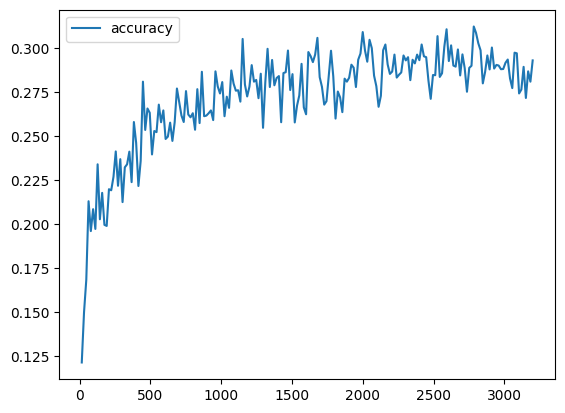

In [ ]:
acc = recorder.metric_names.index('accuracy') - 1
plt.plot(recorder.iters[idx:], L(recorder.values[idx:]).itemgot(acc), label='accuracy')
plt.legend()